Lib

In [ ]:
import numpy as np
import kagglehub
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import pandas as pd


%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


Load data

In [ ]:



path = kagglehub.dataset_download("hassnainzaidi/garbage-classification")

print("Path to dataset files:", path)

100%|██████████| 123M/123M [00:00<00:00, 173MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/hassnainzaidi/garbage-classification/versions/1


In [ ]:
import os
train_dir = os.path.join(path, 'Garbage classification', 'train')
test_dir = os.path.join(path, 'Garbage classification', 'test')
val_dir = os.path.join(path,'Garbage classification', 'val')

Load 2 label datasets

In [ ]:
image_size=(128, 128)
batch_size=32

TARGET_CLASSES = ['plastic', 'paper']

train_ds=image_dataset_from_directory(
    train_dir,
    image_size=image_size,
    batch_size=batch_size,
    class_names = TARGET_CLASSES,
    label_mode='int',
    labels='inferred',
    color_mode='rgb'


)
val_ds=image_dataset_from_directory(
    val_dir,
    class_names = TARGET_CLASSES,
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='int',
    color_mode='rgb'


)
test_ds=image_dataset_from_directory(
    test_dir,
    class_names = TARGET_CLASSES,
    labels='inferred',
    image_size=image_size,
    batch_size=batch_size,
    label_mode='int',
    color_mode='rgb'
)
classes=train_ds.class_names

Found 1076 files belonging to 2 classes.
Found 1076 files belonging to 2 classes.
Found 1076 files belonging to 2 classes.


# Visualize data

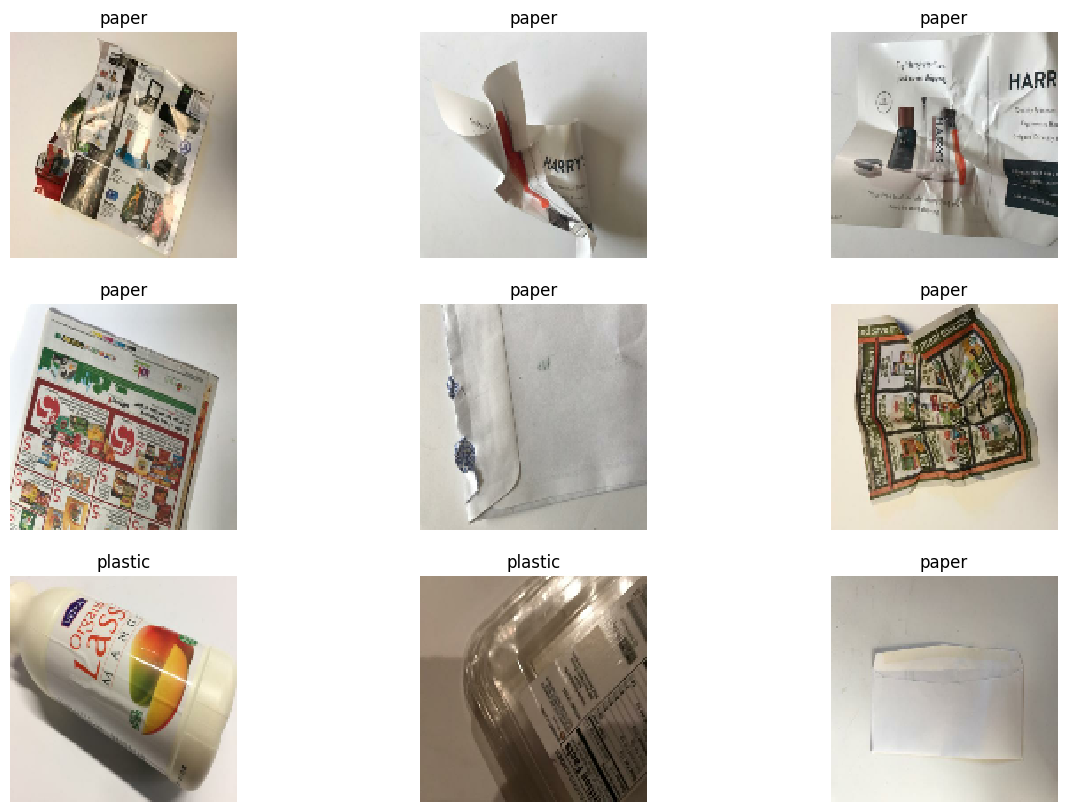

In [ ]:
plt.figure(figsize=(15,10))
for image,label in train_ds.take(1):
  for i in range(9):
   plt.subplot(3,3,i+1)
   plt.imshow(image[i].numpy().astype('int'))
   plt.title(classes[label[i]])
   plt.axis(False)
plt.show()

# Preprocess data

In [ ]:
def preprocess(datasets):
    X_list = []
    y_list = []

    # 1. Thu thập và làm phẳng dữ liệu từ các batches
    for images, labels in datasets:
        x = images.numpy()
        y = labels.numpy()

        # Flatten và Chuẩn hóa
        X_flatten = x.reshape(x.shape[0], -1).T
        X_norm = X_flatten / 255.0

        y_row = y.reshape(1, -1)

        X_list.append(X_norm)
        y_list.append(y_row)

    # 2. Gộp tất cả các list thành ma trận lớn
    X_final = np.concatenate(X_list, axis=1)
    y_final = np.concatenate(y_list, axis=1)


    m = X_final.shape[1]


    permutation = np.random.permutation(m)


    X_shuffled = X_final[:, permutation]
    y_shuffled = y_final[:, permutation]

    return X_shuffled, y_shuffled


train_x, train_y = preprocess(train_ds)
test_x, test_y = preprocess(test_ds)
val_x, val_y = preprocess(val_ds)

N = 500
train_x = train_x[:, :N]
train_y = train_y[:, :N]
val_x = val_x[:, :200]
val_y = val_y[:, :200]
test_x = test_x[:, 100]
test_y = test_y[:, 100]

val_y.shape

(1, 200)

In [ ]:
val_x.shape

(49152, 200)

In [ ]:
print("Kích thước thực tế của train_x:", train_x.shape)
print("Kích thước thực tế của train_y:", train_y.shape)

Kích thước thực tế của train_x: (49152, 500)
Kích thước thực tế của train_y: (1, 500)


Model AI

In [ ]:

n_x =   train_x.shape[0]     # num_px * num_px * 3
n_h1 = 20
n_h2 = 7
n_h3 = 5

n_y = 1
layers_dims = (n_x, n_h1,n_h2,n_h3, n_y)

print(n_x)

49152


Activation

In [ ]:
def relu(z):
    A = np.maximum(0, z)
    cache = z # chinh la z
    return A,cache

def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    cache = Z
    return A, cache

In [ ]:
def init_parameter(n_x, n_h1,n_h2,n_h3,n_y):
    """
    n_x là kích thước input
    n_h là kích thước lớp hidden
    n_y là kích thước output

    Return:
    kiểu dữ liệu dictionay bao gồm:
      - W1: (n_h1, n_x)
          W2: (n_h2, n_h1)
        W3: (n_y, n_h2)
    """
    W1 = np.random.rand(n_h1,n_x) * 0.01
    b1 = np.zeros((n_h1, 1))

    W2 = np.random.randn(n_h2, n_h1) * 0.01
    b2 = np.zeros((n_h2,1))

    W3 = np.random.rand(n_h3, n_h2) * 0.01
    b3 = np.zeros((n_h3,1))

    W4 = np.random.rand(n_y, n_h3) * 0.01
    b4 = np.zeros((n_y,1))

    parameters = {
        "W1":W1,
        "b1": b1,
        "W2": W2,
        "b2": b2,
        "W3" : W3,
        "b3": b3,
        "W4": W4,
        "b4":b4
    }

    return parameters

def linear_activation_forward(A_prev, W,b,activation):

    """
    np.dot() là hàm để tính tích vô hướng scalar thành ma trận 1D
    Z là kết quả của input sau khi nhân với weight và bias, kết quả Z sẽ được
    hàm activation nào đó

    input của hàm này là:
    - A_prev là kết quả của z sau khi tính activation của hàm trước
    - W là trọng số của mô hình có shape như ở hàm trên
    - b là bias cũng đã giải thích
    - activation là hàm kích hoạt


    """
    Z = np.dot(W,A_prev) + b
    linear_cache = (A_prev, W, b)

    if activation == "relu":
        A,activation_cache = relu(Z)
    elif activation == "sigmoid":
        A,activation_cache = sigmoid(Z)

    cache = (linear_cache, activation_cache)
    return A,cache


def compute_cost(AL,Y):

    """
     Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if plastic, 1 if paper), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    m = Y.shape[1] # number of samples
    eps = 1e-15
    ent_cost = (-1/m) * np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))


    return ent_cost

def linear_activation_backward(dA, cache, activation):
    """
    Hàm này làm 3 việc:
    1 là tính gradient tại tâng hiện tại
    2 là lan truyền gradient về tầng phía trước

    Return:
    dA: gradient lan truyền ngược
    dW : gradient của weight
    db: gradient của bias

    Giải thích code như sau:
    đầu tiên là lấy cache của linear cache và của activation
    sau đó là bước tính grad của 1 trong 2 hàm nếu được gọi

    - Nếu hàm activation là relu thì công thức là max(0,z), đạo hàm của hàm này nếu
    z > 0 thì dA = 1, còn <= 0 là bằng 0
    - Nếu activation là sigmoid thì đạo hàm của dZ = dA * s * (1 - s)

    """
    linear_cache,activation_cache = cache
    A_prev, W,b = linear_cache
    Z = activation_cache

    m = A_prev.shape[1] # nums inputshape

    if activation == "relu":
        dZ = np.array(dA, copy=True)
        dZ[Z<=0]  = 0
    elif activation == "sigmoid":
        s = 1 / (1 + np.exp(-Z))
        dZ = dA * s * (1 - s)

    dW = (1/m) * np.dot(dZ, A_prev.T)

    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

def update_parameters(parameters, dW1, db1, dW2, db2,dW3, db3, dW4, db4, learning_rate):
    # Cập nhật các giá trị trong từ điển parameters
    parameters["W1"] = parameters["W1"] - learning_rate * dW1
    parameters["b1"] = parameters["b1"] - learning_rate * db1
    parameters["W2"] = parameters["W2"] - learning_rate * dW2
    parameters["b2"] = parameters["b2"] - learning_rate * db2
    parameters["W3"] = parameters["W3"] - learning_rate * dW3
    parameters["b3"] = parameters["b3"] - learning_rate * db3
    parameters["W4"] = parameters["W4"] - learning_rate * dW4
    parameters["b4"] = parameters["b4"] - learning_rate * db4

    return parameters

### L - layer model

In [ ]:
def initialize_parameters_deep(layer_dims):
    """
    layer_dims: list chứa số neuron mỗi layer
    ví dụ: [12288, 64, 32, 16, 1]
    """
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters[f"W{l}"] = np.random.randn(
            layer_dims[l], layer_dims[l-1]
        ) * 0.01
        parameters[f"b{l}"] = np.zeros((layer_dims[l], 1))

    return parameters
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2


    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(
            A_prev,
            parameters[f"W{l}"],
            parameters[f"b{l}"],
            "relu"
        )
        caches.append(cache)


    AL, cache = linear_activation_forward(
        A,
        parameters[f"W{L}"],
        parameters[f"b{L}"],
        "sigmoid"
    )
    caches.append(cache)

    return AL, caches
def compute_cost(AL, Y):
    m = Y.shape[1]
    AL = np.clip(AL, 1e-15, 1 - 1e-15)

    cost = (-1/m) * np.sum(
        Y*np.log(AL) + (1-Y)*np.log(1-AL)
    )
    return cost
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = Y.shape[1]

    Y = Y.reshape(AL.shape)

    # Output layer
    dAL = -(Y/AL - (1-Y)/(1-AL))
    grads[f"dA{L-1}"], grads[f"dW{L}"], grads[f"db{L}"] = \
        linear_activation_backward(
            dAL, caches[L-1], "sigmoid"
        )

    # Hidden layers
    for l in reversed(range(L-1)):
        dA_prev, dW, db = linear_activation_backward(
            grads[f"dA{l+1}"],
            caches[l],
            "relu"
        )
        grads[f"dA{l}"] = dA_prev
        grads[f"dW{l+1}"] = dW
        grads[f"db{l+1}"] = db

    return grads

def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2

    for l in range(1, L+1):
        parameters[f"W{l}"] -= learning_rate * grads[f"dW{l}"]
        parameters[f"b{l}"] -= learning_rate * grads[f"db{l}"]

    return parameters

def L_layer_model(X, Y, x_val, y_val, layer_dims,
                  learning_rate=0.0075,
                  epochs=2500,
                  print_cost=False):

    np.random.seed(1)
    parameters = initialize_parameters_deep(layer_dims)
    costs = []
    costs_val = []

    for i in range(epochs):

        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)


        parameters = update_parameters(parameters, grads, learning_rate)


        if i % 100 == 0:

            AL_val, _ = L_model_forward(x_val, parameters)
            cost_val = compute_cost(AL_val, y_val)

            costs.append(cost)
            costs_val.append(cost_val)

            if print_cost:
                print(f"Epoch {i} | Train Loss: {cost:.4f} | Val Loss: {cost_val:.4f}")

    # Vẽ đồ thị

    plt.plot(costs, label='Train Loss', color='blue')
    plt.plot(costs_val, label='Val Loss', color='orange')
    plt.title(f"Loss Over Time (Learning rate = {learning_rate})")
    plt.xlabel("Iterations (x100)")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    return parameters


Epoch 0 | Train Loss: 0.6932 | Val Loss: 0.6931
Epoch 100 | Train Loss: 0.6898 | Val Loss: 0.6920
Epoch 200 | Train Loss: 0.6878 | Val Loss: 0.6918
Epoch 300 | Train Loss: 0.6864 | Val Loss: 0.6920
Epoch 400 | Train Loss: 0.6855 | Val Loss: 0.6922
Epoch 500 | Train Loss: 0.6844 | Val Loss: 0.6920
Epoch 600 | Train Loss: 0.6825 | Val Loss: 0.6905
Epoch 700 | Train Loss: 0.6772 | Val Loss: 0.6854
Epoch 800 | Train Loss: 0.6587 | Val Loss: 0.6679
Epoch 900 | Train Loss: 0.5879 | Val Loss: 0.5997
Epoch 1000 | Train Loss: 0.5787 | Val Loss: 0.5669
Epoch 1100 | Train Loss: 0.5448 | Val Loss: 0.5442
Epoch 1200 | Train Loss: 0.5178 | Val Loss: 0.5276
Epoch 1300 | Train Loss: 0.4928 | Val Loss: 0.5140
Epoch 1400 | Train Loss: 0.4738 | Val Loss: 0.5025
Epoch 1500 | Train Loss: 0.4594 | Val Loss: 0.4958
Epoch 1600 | Train Loss: 0.4372 | Val Loss: 0.4840
Epoch 1700 | Train Loss: 0.4220 | Val Loss: 0.4751
Epoch 1800 | Train Loss: 0.4098 | Val Loss: 0.4697
Epoch 1900 | Train Loss: 0.3942 | Val Loss:

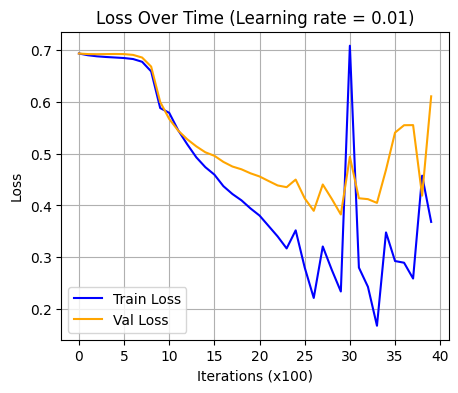

In [ ]:
layer_dims = [49152, 64,32, 1]
parameters = L_layer_model(
    train_x, train_y,val_x,val_y,
    layer_dims,
    learning_rate=0.01,
    epochs=4000,
    print_cost=True
)



In [ ]:
def compute_accuracy(test_ds, parameters):
    correct = 0
    total = 0

    for images, labels in test_ds:
        # images: (batch, H, W, C)
        # labels: (batch,)

        batch_size = images.shape[0]

        for i in range(batch_size):
            # preprocess 1 ảnh
            X = images[i].numpy().reshape(-1, 1) / 255.0
            y_true = int(labels[i].numpy())

            # predict
            y_pred, _ = predict(X, parameters)
            y_pred = int(y_pred[0, 0])

            if y_pred == y_true:
                correct += 1
            total += 1

    accuracy = correct / total
    return accuracy


In [ ]:
def predict(X, parameters):
    # Perform forward propagation using the L_model_forward function
    AL, _ = L_model_forward(X, parameters)
    # Threshold the output to get binary predictions (0 or 1)
    predictions = (AL > 0.5).astype(int)
    return predictions, AL

print("Train acc:", compute_accuracy(train_ds, parameters))
print("Test acc :", compute_accuracy(test_ds, parameters))

Train acc: 0.800185873605948
Test acc : 0.800185873605948


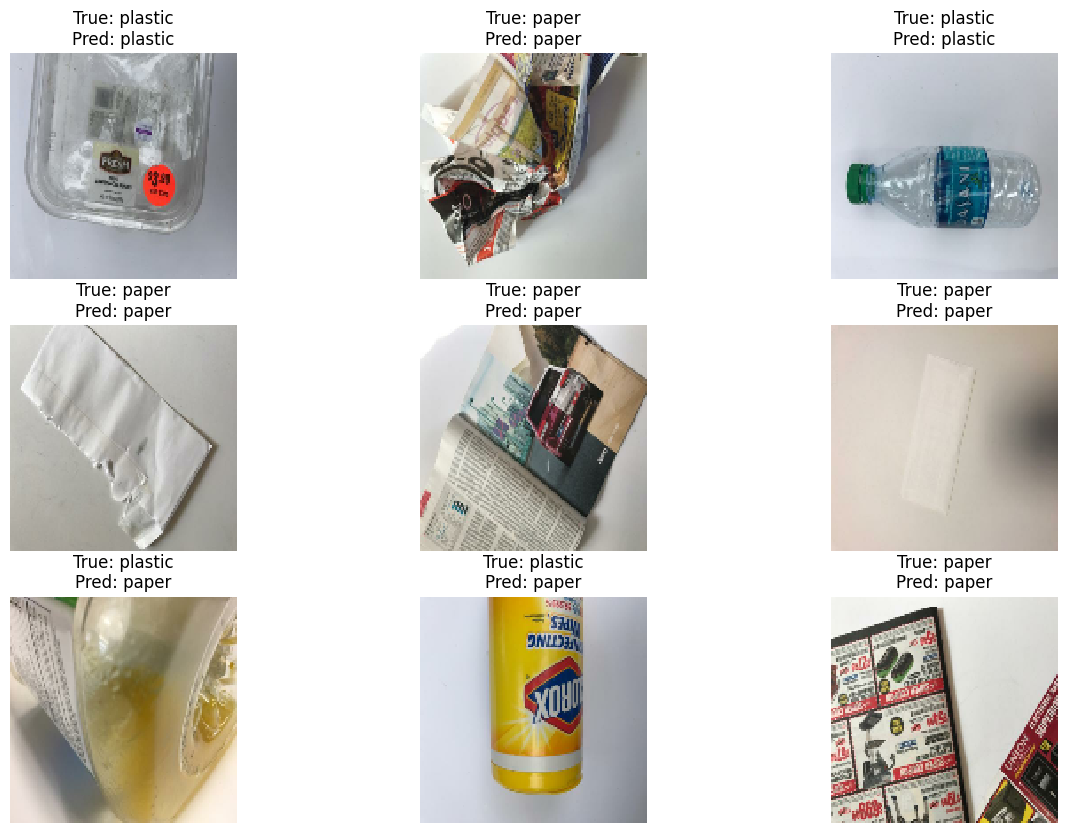

In [ ]:


plt.figure(figsize=(15,10))

# Get a batch of images and labels from the test dataset
for images, labels in test_ds.take(1):
    for i in range(9):
        # Get the actual image and label
        image_to_show = images[i].numpy().astype('int')
        true_label = classes[labels[i].numpy()]

        # Preprocess a single image for prediction
        single_image_x = images[i].numpy().reshape(1, -1).T / 255.0

        # Make prediction for the single image
        y_pred, _ = predict(single_image_x, parameters)
        predicted_label = classes[y_pred[0,0]]

        plt.subplot(3,3,i+1)
        plt.imshow(image_to_show)
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis(False)
plt.show()

Epoch 0 | Train Loss: 0.6932 | Val Loss: 0.6932
Epoch 100 | Train Loss: 0.6930 | Val Loss: 0.6928
Epoch 200 | Train Loss: 0.6928 | Val Loss: 0.6923
Epoch 300 | Train Loss: 0.6926 | Val Loss: 0.6919
Epoch 400 | Train Loss: 0.6925 | Val Loss: 0.6915
Epoch 500 | Train Loss: 0.6923 | Val Loss: 0.6911
Epoch 600 | Train Loss: 0.6922 | Val Loss: 0.6907
Epoch 700 | Train Loss: 0.6920 | Val Loss: 0.6903
Epoch 800 | Train Loss: 0.6919 | Val Loss: 0.6900
Epoch 900 | Train Loss: 0.6917 | Val Loss: 0.6896
Epoch 1000 | Train Loss: 0.6916 | Val Loss: 0.6893
Epoch 1100 | Train Loss: 0.6915 | Val Loss: 0.6890
Epoch 1200 | Train Loss: 0.6914 | Val Loss: 0.6887
Epoch 1300 | Train Loss: 0.6913 | Val Loss: 0.6884
Epoch 1400 | Train Loss: 0.6912 | Val Loss: 0.6881
Epoch 1500 | Train Loss: 0.6911 | Val Loss: 0.6878
Epoch 1600 | Train Loss: 0.6910 | Val Loss: 0.6875
Epoch 1700 | Train Loss: 0.6909 | Val Loss: 0.6873
Epoch 1800 | Train Loss: 0.6908 | Val Loss: 0.6870
Epoch 1900 | Train Loss: 0.6908 | Val Loss:

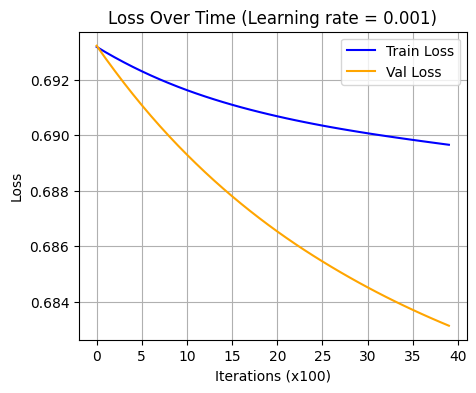

In [ ]:
layer_dims = [49152, 64,32, 1]
parameters = L_layer_model(
    train_x, train_y,val_x,val_y,
    layer_dims,
    learning_rate=0.001,
    epochs=4000,
    print_cost=True
)



In [ ]:
def predict(X, parameters):
    # Perform forward propagation using the L_model_forward function
    AL, _ = L_model_forward(X, parameters)
    # Threshold the output to get binary predictions (0 or 1)
    predictions = (AL > 0.5).astype(int)
    return predictions, AL

print("Train acc:", compute_accuracy(train_ds, parameters))
print("Test acc :", compute_accuracy(test_ds, parameters))

Train acc: 0.5520446096654275
Test acc : 0.5520446096654275
